In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import pca,truncated_svd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator,TransformerMixin
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
X_train = pd.read_csv('dengue_features_train.csv')
y_train = pd.read_csv('dengue_labels_train.csv')
X_test = pd.read_csv('dengue_features_test.csv')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

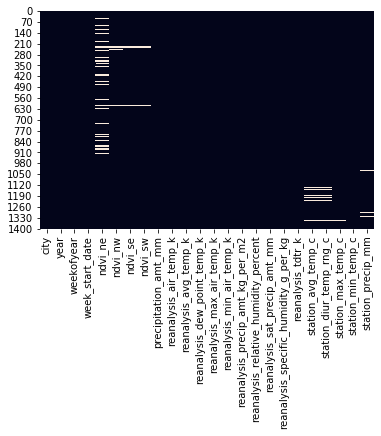

In [4]:
sns.heatmap(X_train.isnull(),cbar=False)

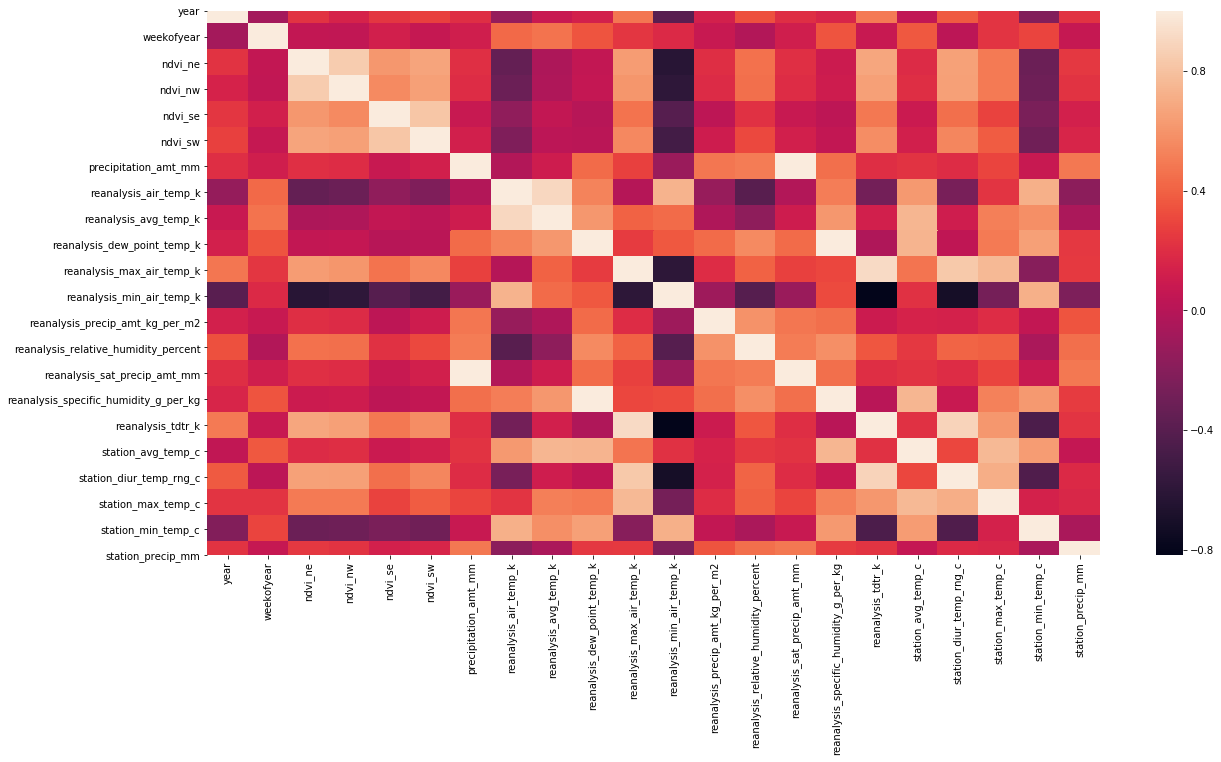

In [5]:
plt.figure(figsize=(20,10))
sns.heatmap(X_train.corr())

In [6]:
def makePrediction(model):
    model.fit(X_train,y_train['total_cases'].values.reshape(-1,1))
    y_predict = X_test[['city', 'year', 'weekofyear']]
    y_predict['total_cases'] = model.predict(X_test).astype(int)
    y_predict.to_csv(datetime.now().strftime("%Y%m%d%H%M%S")+"prediction.csv",index=False)

In [11]:
int_columns = X_train.select_dtypes(include=['integer']).columns
Model1 = Pipeline([
    ('int_column_selector',ColumnTransformer([
        ('column_selector',IterativeImputer(),int_columns)
    ])),
    ('predictor', RandomForestRegressor())
]);
makePrediction(Model1);

D:\Study\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Study\anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
D:\Study\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
intfloat_columns = X_train.select_dtypes(include=['integer','float']).columns
Model2 = Pipeline([
    ('int_column_selector',ColumnTransformer([
        ('column_selector',IterativeImputer(),intfloat_columns),
        ('ct',OneHotEncoder(),['city'])
    ])),
    ('predictor', RandomForestRegressor())
]);
makePrediction(Model2);

Index(['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [7]:
class extractMonthday(BaseEstimator,TransformerMixin):
    def __init__(self,dateCol):
        self.dateCol = dateCol
        pass
    def fit(self,X,y=None):
        self.X = X.copy()
        return self
    def transform(self,X,y=None):
        self.X['month'] = self.X[self.dateCol].apply(lambda x: x.split('-')[1]).astype(int)
        self.X['day'] = self.X[self.dateCol].apply(lambda x: x.split('-')[2]).astype(int)
        return self.X.drop(self.dateCol,axis=1)
    
Model3 = Pipeline([
    ('emy',extractMonthday('week_start_date')),
    ('city_ct',ColumnTransformer([
        ('ct',OneHotEncoder(),['city'])
    ],remainder='passthrough')),
    ('Ii',IterativeImputer(estimator=Ridge(),add_indicator=True,max_iter=30)),
    ('preditor',RandomForestRegressor())
]);

makePrediction(Model3);